In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy import stats
import math
import pandas as pd
import ipywidgets
from scipy.optimize import curve_fit
import plotly.express as px
from numpy import mean, std

#from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, scale_x_continuous, scale_y_continuous
#from plotnine.data import mpg

In [2]:
xAxisTicks=[-0.300 , -0.233, -0.167, -0.100 , -0.033, 0.033, 0.100 ,0.167, 0.233, 0.300]
class modeled_time_perception:
    def outlier_remover(self,data,variable):
        mean_tmp, std_tmp=data[variable].mean(), data[variable].std()
        rows_to_delete_lower = data[data["pTemporalError"]<mean_tmp-1.5*std_tmp].index
        rows_to_delete_upper = data[data["pTemporalError"]>mean_tmp+1.5*std_tmp].index
        data = data.drop(rows_to_delete_lower)
        data = data.drop(rows_to_delete_upper)
        return data
    def modelPerceivedTime2(self,x,alpha,beta):
        return alpha*np.sin(1*math.pi*x)+beta*x
    def __init__(self,data_folder,data,data_test):
        df=pd.read_csv(data_folder+data) #
        #df=df[df["perceivedTime"].notna()]
        #df=df[df["target.started"].notna()]
        #df_test=df[df["isTrial"]=="testSingleStim"]
        #df=df[df["congruency"]=="unmet"]
        def clean_data(datam):
            datam["delayS"]=datam["delay"]/1000
            datam["pTemporalError"]=datam["perceivedTime"]-datam["target.started"]# Calculate temporalError
            datam["pTemporalErrorMs"]=datam["pTemporalError"]*1000
            datam["physicalDelay"]=datam["distractor.started"]-datam["target.started"]
            datam["physicalDelayMs"]=datam["physicalDelay"]*1000
            return datam
        if data_test!=None:
            df_pre_trial=pd.read_csv(data_folder+data_test)
        else:
            df_pre_trial=df
        ## clean data function

        df=clean_data(df)
        df_pre_trial=clean_data(df_pre_trial)
        self.data_unchanged=df

        self.df_test=df_pre_trial[df_pre_trial["isTrial"]=="testSingleStim"]
        df_test=df_pre_trial[df_pre_trial["isTrial"]=="testSingleStim"]
        ##### fit data to model
        df_tmp=df_test
        ## Remove the outliers
        df_tmp=self.outlier_remover(df_tmp,"pTemporalError")
        ## fit model to to perceived time
 
        parameters, covariance = curve_fit(self.modelPerceivedTime2, df_tmp["target.started"], df_tmp["perceivedTime"])
        fit_A , fit_B = parameters[0] , parameters[1]
        preditcedPerceivedTime = self.modelPerceivedTime2(df["target.started"], fit_A, fit_B)
        ## assign new variables to df
        df["predictedPerceivedTime"]=preditcedPerceivedTime # take fitted perceived time to the data
        df["pTemporalErrorFitted"]=df["perceivedTime"]-df["predictedPerceivedTime"] # calculate temporal error based on predicted time
        if data==data_Omer2:   df=df.iloc[40:] # exceptional for Omer2 85 percent expectation data
        ## meaningless perceived error calculation by delta means
        avgError=np.mean(df_test["perceivedTime"]-df_test["target.started"])
        df["pTemporalErrorAvaraged"]=df["pTemporalError"]-avgError
        ## assign datas to self
        df_trial=df[df["isTrial"]=="trial"]
        df_trial=df_trial[df_trial["pTemporalError"].notna()]
        self.df_test=df[df["isTrial"]=="testSingleStim"]
        self.df_trial=df_trial
        self.df_long=df
        data_name=data
        self.data_name=data_name
        self.df_unmet=df_trial[df_trial["congruency"]=="unmet"]
        self.df_met=df_trial[df_trial["congruency"]=="met"]

    def model_time_base(self,delay,alpha,sigma):
        modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2) for x in delay]
        return modelPerceivedError
    
    def modelPTime(self,delay,alpha,sigma,teta):
        modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+teta for x in delay]
        return modelPerceivedError
    def model_expectation_met(self,delay,alpha,sigma,delta,teta):
        modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**4)+teta for x in delay]
        return modelPerceivedError
    def model_expectation_unmet(self,delay,alpha,sigma,teta,delta=1):
        modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**5)+teta for x in delay]
        return modelPerceivedError    

    # Get meaans grouped by constant target-distractor delay
    def get_means(self,data):
        #df=clean_data(data=data_Erva)
        df_means=data.groupby('delayS').median()
        df_stdDev=data.groupby("delayS").std()
        a=list(df_means["delay"].unique())
        a.sort()
        df_means["delayMs"]=a
        del a
        xdata=df_means["physicalDelay"]
        ydata=df_means["pTemporalErrorFitted"]
        return xdata, ydata

    def plot_base_model(self,means,plotly=False):
        if means==True:
            xdata,ydata=self.get_means(self.df_trial)
        else:
            xdata,ydata=self.df_trial["physicalDelay"],self.df_trial["pTemporalErrorFitted"]
        #parameters, covariance = curve_fit(self.model_time_base, xdata, ydata)
        parameters, covariance = curve_fit(self.modelPTime, xdata, ydata)
        fit_A, fit_B = parameters[0], parameters[1]
        #print(fit_A,fit_B)
        middleInt=np.linspace(-0.35,0.35,100)
        fit_k = self.modelPTime(middleInt, fit_A, fit_B,parameters[2])
        ## Plot using matplotlib
        plt.figure(figsize=(15, 12))
        plt.plot(xdata, ydata, 'o', label='data')
        plt.plot(middleInt, fit_k, '-', label='fit')
        plt.axvline(x=0, color='black', linestyle='dotted')
        plt.axhline(y=0, color='black', linestyle='dotted')
        sns.regplot(xdata, ydata, ci=None,label="regression")
        plt.title("Temporal errors of "+self.data_name.split('_')[0])
        plt.ylabel("Perceived Temporal Error (s)")
        plt.xlabel("Delay D-T s")
        plt.ylim(-0.4,0.4)
        plt.yticks(list(np.linspace(-0.4,0.4,11)))
        plt.xticks(xAxisTicks)
        plt.legend()
        SE = np.sqrt(np.diag(covariance))
        SE_A , SE_B= SE[0], SE[1]
        #print(F'The value of A is {fit_A:.5f} with standard error of {SE_A:.5f}.')
        #print(F'The value of B is {fit_B:.5f} with standard error of {SE_B:.5f}.')

    def fitter(self,means=1,congruency="met"):
        df_to_fit=self.df_trial[self.df_trial["congruency"]==congruency]
        df_to_fit=df_to_fit[df_to_fit["pTemporalError"]<2]
        df_to_fit=df_to_fit[df_to_fit["pTemporalError"]>-2]
        #df_to_fit=self.outlier_remover(df_to_fit,"pTemporalError")
        if means==True:  xdata,ydata=self.get_means(df_to_fit)
        else:  xdata,ydata=df_to_fit["physicalDelay"],df_to_fit["pTemporalErrorFitted"]
        x=x=np.linspace(min(xdata),max(xdata),200)
        if congruency=="met":   
            params, covariance = curve_fit(self.model_expectation_met, xdata, ydata)
            fited_errors = self.model_expectation_met(x, params[0],params[1],params[2],params[3])
        else:
            params, covariance = curve_fit(self.model_expectation_unmet, xdata, ydata,maxfev=2000)
            fited_errors = self.model_expectation_unmet(x, params[0],params[1],params[2],params[3])
        fit_alpha,fit_sigma,fit_teta= params[0],params[1],params[2]
        np.sqrt(np.diag(covariance))
        print(np.sqrt(np.diag(covariance)))
        print("for "+congruency+" condition fit alpha is :" +str(fit_alpha)+" fit sigma is :"+str(fit_sigma)+"fit teta : "+ str(fit_teta))
        return x,fited_errors,xdata,ydata,congruency
    def plotter(self,x,fit_y,xdata,ydata,congruency):
        plt.figure(figsize=(15, 12))
        plt.plot(xdata, ydata, 'o', label='data')
        plt.plot(x, fit_y, '-', label='fit')
        plt.axvline(x=0, color='black', linestyle='dotted')
        plt.axhline(y=0, color='black', linestyle='dotted')
        #sns.regplot(xdata, ydatak, ci=None,label="regression")
        plt.title("Temporal errors of "+self.data_name.split('_')[0]+congruency+" trials")
        plt.ylabel("Perceived Temporal Error (s)")
        plt.xlabel("Delay D-T s")
        plt.ylim(-0.3, +0.3)
        plt.yticks(list(np.linspace(-0.35,0.35,11)))
        #plt.yticks(10)
        plt.xticks(xAxisTicks)
        plt.legend()
  
    def perceived_actual(self):
        plt.figure(figsize=(15, 12))
        y=self.df_trial["perceivedTime"]
        x=self.df_trial["target.started"]
        plt.plot(x,y,'o')
        plt.plot(np.linspace(0,2,100),np.linspace(0,2,100))
        sns.regplot(x, y, ci=None)

### Hard coded data paths

In [3]:
# Data paths
path="C:/Users/omeru/Documents/Omer_Repos/Internship Pascal/analysis/data/"
data_Erva="erva50_pilot_base_expectation_shapes_perceived_time_2023-03-16_23h46.19.804.csv" # no expectation
data_Erva_70="erva07_expectation_shapes_perceived_time_2023-03-23_20h55.33.677.csv"
data_Erva80="erva80G_expectation_shapes_perceived_time_2023-04-07_23h25.04.855.csv"

data_nicola_85_1="nicola_85_1_expectation_shapes_perceived_time_2023-03-28_15h04.34.263.csv"
data_Nicola=  'nicola_base_pilot_expectation_shapes_perceived_time_2023-03-20_15h03.16.305.csv'# no expectation

data_Omer="299271_expectation_shapes_perceived_time_2023-03-19_15h42.48.633.csv" # no expectation
data_Omer2="omer85_high_exp_expectation_shapes_perceived_time_2023-03-17_12h35.14.339.csv" # expectation
data_omer_70="omer70_expectation_shapes_perceived_time_2023-03-27_21h43.36.152.csv" #expected 70 percent
data_omer_80G="omer80G_expectation_shapes_perceived_time_2023-04-03_14h30.36.416.csv" #expected 80 percent

data_elaine80R="elaine08R_expectation_shapes_perceived_time_2023-04-13_17h14.41.421.csv" #expected 80 percent

data_marika="marika_expectedh2_expectation_shapes_perceived_time_2023-04-28_16h29.23.427.csv"

data_ahmed_high="ahmed_high0_cont_expectation_shapes_perceived_time_2023-04-29_14h47.24.687.csv"

data_sarah_high="sarah_high1_expectation_shapes_perceived_time_2023-04-29_16h58.53.797.csv"

datas="datas.csv"
datas_expecataions_80=[data_Erva80,data_omer_80G,data_nicola_85_1,data_elaine80R]


## 0- This is the path to the data folder and clean data 

In [4]:
# Data loading and seperating
def load_data(data_folder,data,data_test):
    a=modeled_time_perception(data_folder,data,data_test)
    df_trial=a.df_trial
    df_test=a.df_test
    df_long=a.df_long
    df_met=a.df_met
    df_unmet=a.df_unmet
    df_name=a.data_name
    return a,df_trial,df_test,df_long,df_met,df_unmet,df_name

df_obj,df_trial,df_test,df_long,df_met,df_unmet,df_name=load_data(path,data_elaine80R,None)


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



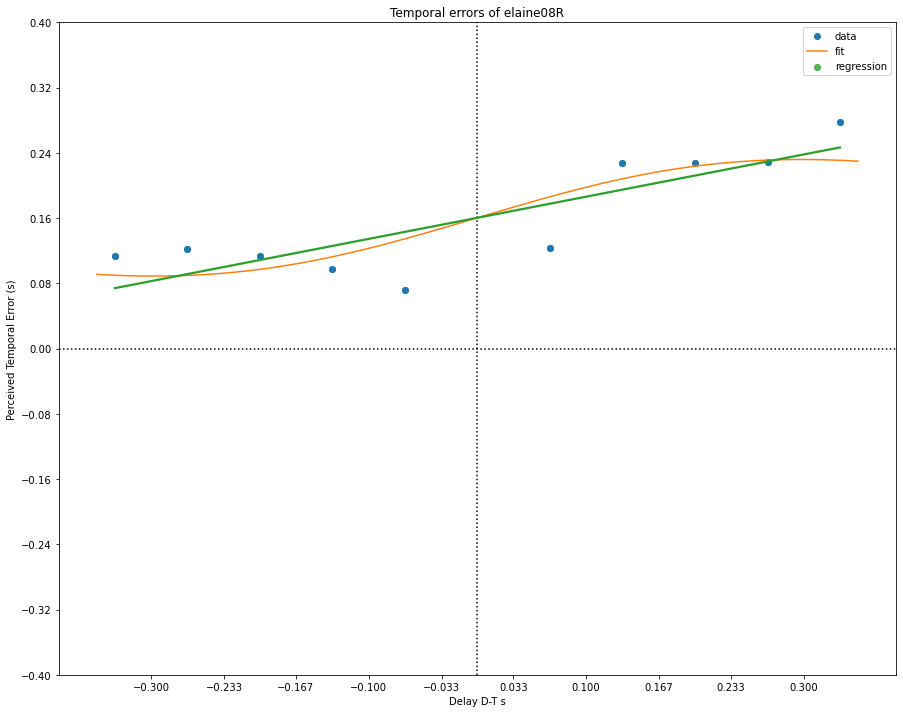

In [5]:
df_obj.plot_base_model(means=1)

## 1 - Model perceived time
### $y = \alpha \cdot \sin(\pi  x) + \beta \cdot x$




c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



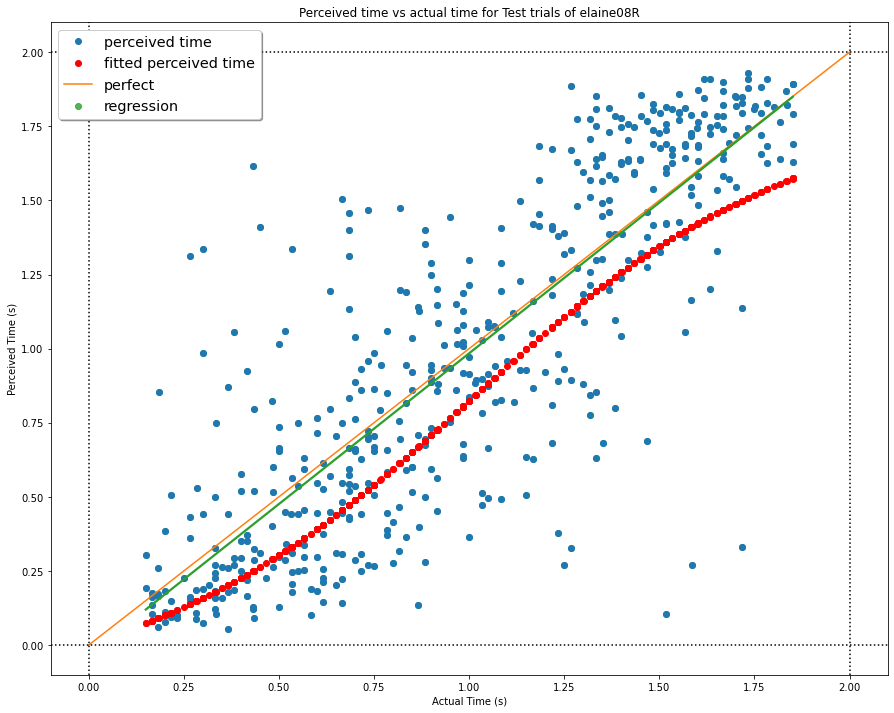

In [6]:
def modelPerceivedTime(x,alpha,beta):
    return alpha*np.sin(1*math.pi*x)+beta*x

def plot_perceived_actual(df_trial):
    plt.figure(figsize=(15, 12))
    plt.plot(df_trial["target.started"],df_trial["perceivedTime"],'o',label="perceived time")
    plt.plot(df_trial["target.started"],df_trial["predictedPerceivedTime"],'ro',label="fitted perceived time")
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),label="perfect")
    sns.regplot(df_trial["target.started"],df_trial["perceivedTime"], ci=None,label="regression")
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axhline(y=2, color='black', linestyle='dotted')
    plt.title("Perceived time vs actual time for Test trials of "+df_name.split('_')[0])
    plt.ylabel("Perceived Time (s)")
    plt.xlabel("Actual Time (s)")
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(df_trial)

## 2. Perceived Error over all trials with baseline equation for temporal error (not considering the effect of the expectation)

## 3. Perceived Error over Expected(met) and Unexpected(unmet) trials with different models for temporal error
### 3.1 - For expected trials, the model is:
#### $Perceived Error=\alpha \frac{x}{\sigma} \exp\left(-\frac{x^2}{\sigma^2}\right) + \delta x^4 + \theta$
### 3.2 - For unexpected trials, the model is: 
#### $Perceived Error=α(x/σ)exp(-x^2/σ^2) + δx^5 + θ$


[0.06421821 0.37039091 3.60674146 0.02173053]
for met condition fit alpha is :0.1608511401857237 fit sigma is :0.4421292931856416fit teta : 6.56457123256358
[2.88315725e+09 7.87624716e+09 3.15372535e-02 1.04016518e+02]
for unmet condition fit alpha is :309.5952290697169 fit sigma is :845.7487743293916fit teta : 0.11499130711409568
[0.06421821 0.37039091 3.60674146 0.02173053]
for met condition fit alpha is :0.1608511401857237 fit sigma is :0.4421292931856416fit teta : 6.56457123256358
[2.88315725e+09 7.87624716e+09 3.15372535e-02 1.04016518e+02]
for unmet condition fit alpha is :309.5952290697169 fit sigma is :845.7487743293916fit teta : 0.11499130711409568


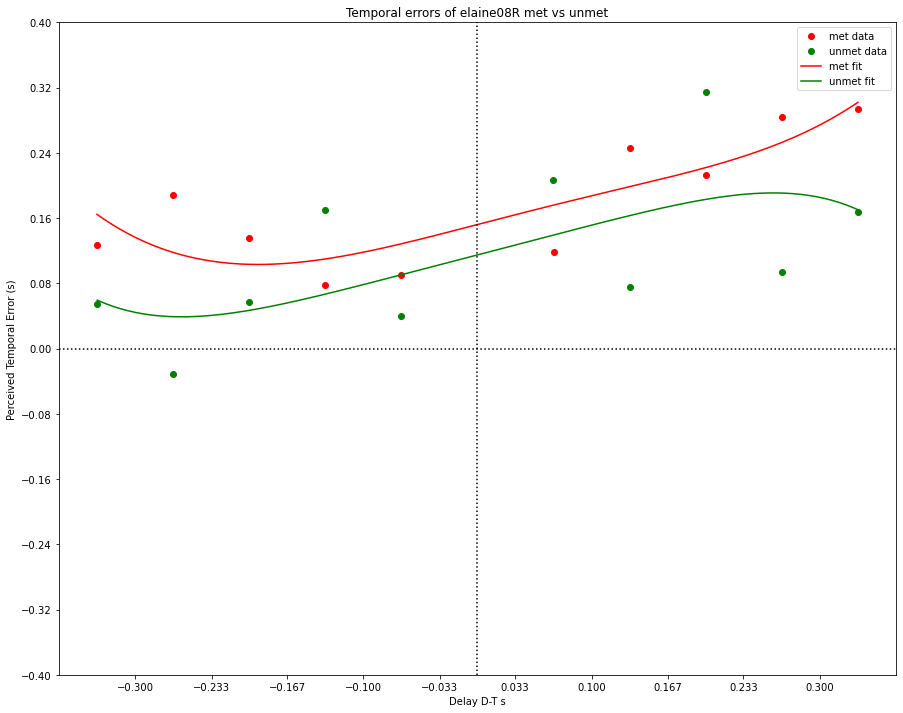

[0.04324252 0.11953836 3.1335961  0.01942841]
for met condition fit alpha is :-0.14662406727287156 fit sigma is :-0.3062063341827327fit teta : 6.653174224092399
[1.15868311e-01 2.97291885e-01 3.56734600e-02 4.67163477e+01]
for unmet condition fit alpha is :0.22175545349483863 fit sigma is :0.26160066637914653fit teta : 0.09509022227440878


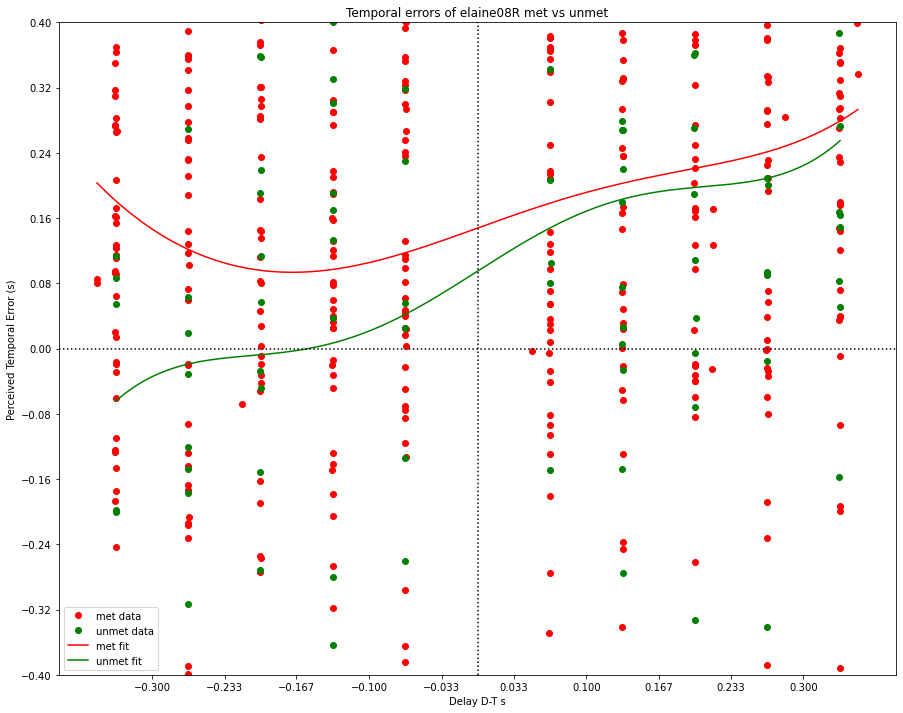

In [7]:
mets=df_obj.fitter(means=1,congruency="met")
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=df_obj.fitter(means=1,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])
#a.plotter(x,fit_y,xdata,ydata,congruency
def plot_mets_unmets(mets,unmets):
    plt.figure(figsize=(15, 12))
    plt.plot(mets[2], mets[3], 'o', label='met data',color='red')
    plt.plot(unmets[2], unmets[3], 'o', label='unmet data',color='green')

    plt.plot(mets[0], mets[1], '-', label='met fit',color='red')
    plt.plot(unmets[0], unmets[1], '-', label='unmet fit',color='green')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #sns.regplot(xdata, ydatak, ci=None,label="regression")
    plt.title("Temporal errors of "+df_obj.data_name.split('_')[0]+" met vs unmet")
    plt.ylabel("Perceived Temporal Error (s)")
    plt.xlabel("Delay D-T s")
    lim=0.4
    plt.ylim(-lim, +lim)
    plt.yticks(list(np.linspace(-lim,lim,11)))
    #plt.yticks(10)
    plt.xticks(xAxisTicks)
    plt.legend()
    plt.show()

mets=df_obj.fitter(means=1,congruency="met")
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=df_obj.fitter(means=1,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])  
plot_mets_unmets(mets,unmets)
mets=df_obj.fitter(means=0,congruency="met")
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=df_obj.fitter(means=0,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])
plot_mets_unmets(mets,unmets)

## 2 - Reaction Time

1.1327038000000005
1.23294599998917


(0.0, 2.0)

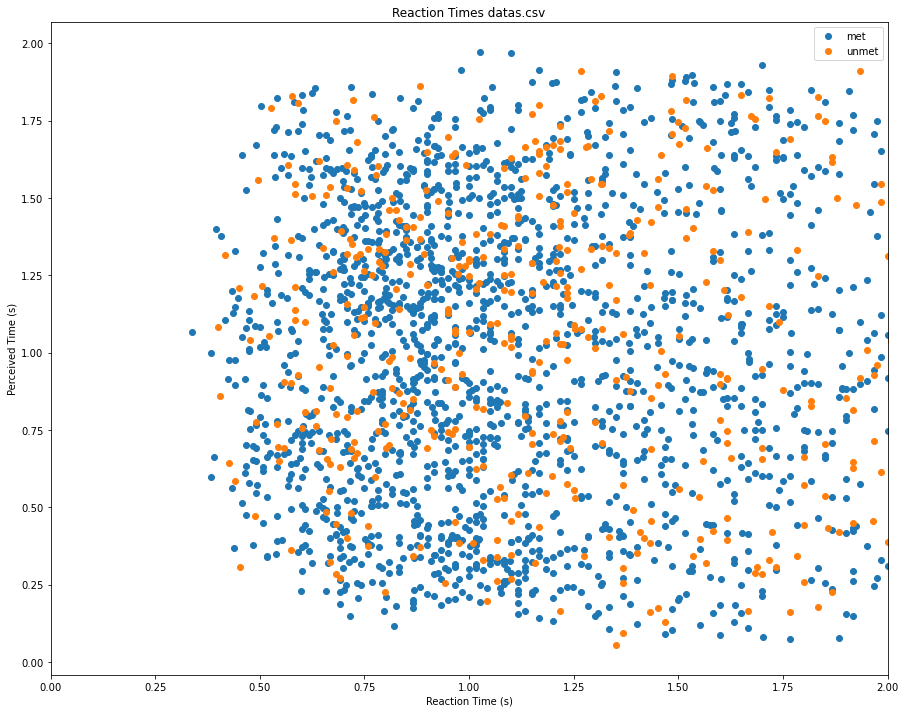

In [21]:
print(np.median(df_met["rt_total"]))
print(np.median(df_unmet["rt_total"]))
plt.figure(figsize=(15, 12))
plt.plot(df_met["rt_total"],df_met["perceivedTime"],'o',label="met")
plt.plot(df_unmet["rt_total"],df_unmet["perceivedTime"],'o',label="unmet")
plt.title("Reaction Times "+df_name.split('_')[0])
plt.ylabel("Perceived Time (s)")
plt.xlabel("Reaction Time (s)")
plt.legend()
plt.xlim(0,2)

# Repat all created graphs analysis for data retrieved for high expectation pilots 



In [84]:
from IPython.core.display import display, HTML, Markdown
from IPython.display import display_markdown
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))



# ANALYSIS of erva80G DTATA

## 1 - Perceived time vs actual time for Test trials of erva80G data

## 2 - Perceived Error over all trials with baseline equation for temporal error (not considering the effect of the expectation)

## 2.2.1 - Perceived time vs actual time for met trials

## 2.2.2 - Perceived time vs actual time for unmet trials

[9.31889453e+09 2.72061094e+10 2.00777990e+00 1.22974252e-02]
for met condition fit alpha is :2651.5606159934982 fit sigma is :7741.116334452194fit teta : -8.925258625892665
[3.22313900e+07 1.80883881e+08 2.58976646e-02 1.27005522e+02]
for unmet condition fit alpha is :41.19306792551355 fit sigma is :231.1643604933651fit teta : 0.1964098531833604


## 3.1 Perceived Error over Expected(met) trials

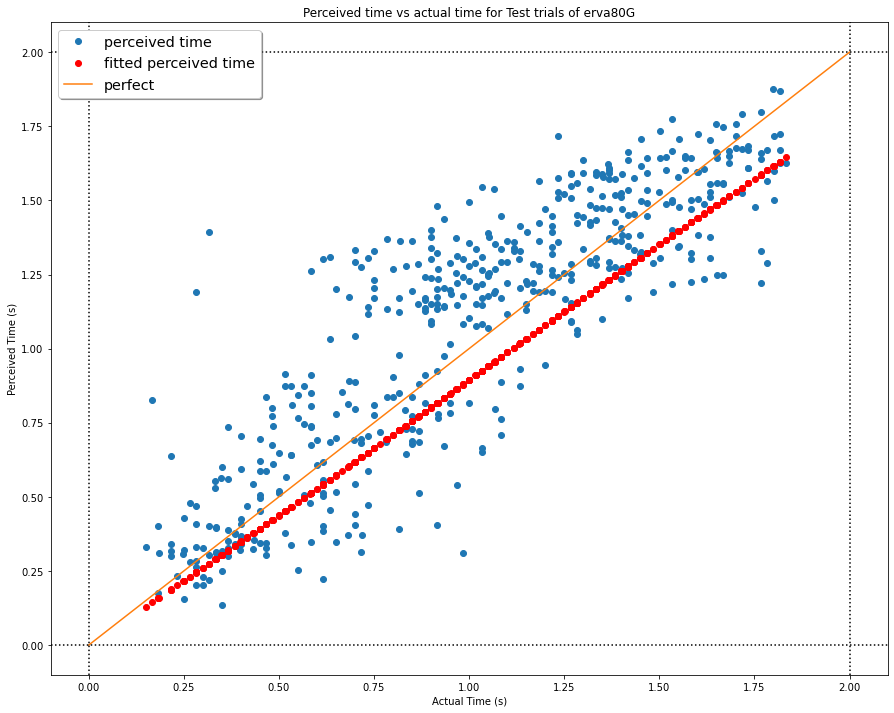

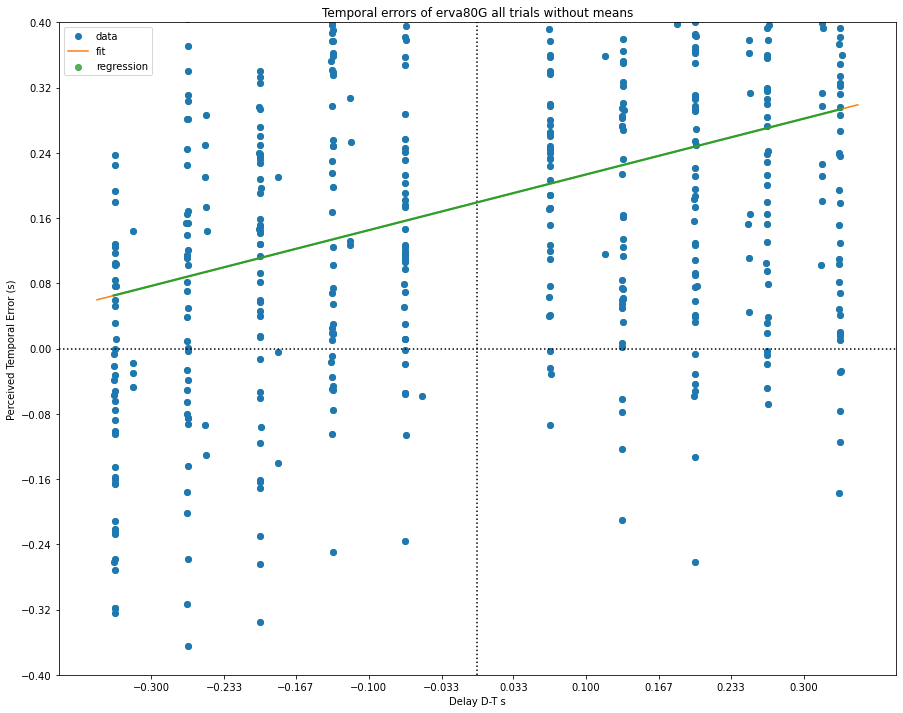

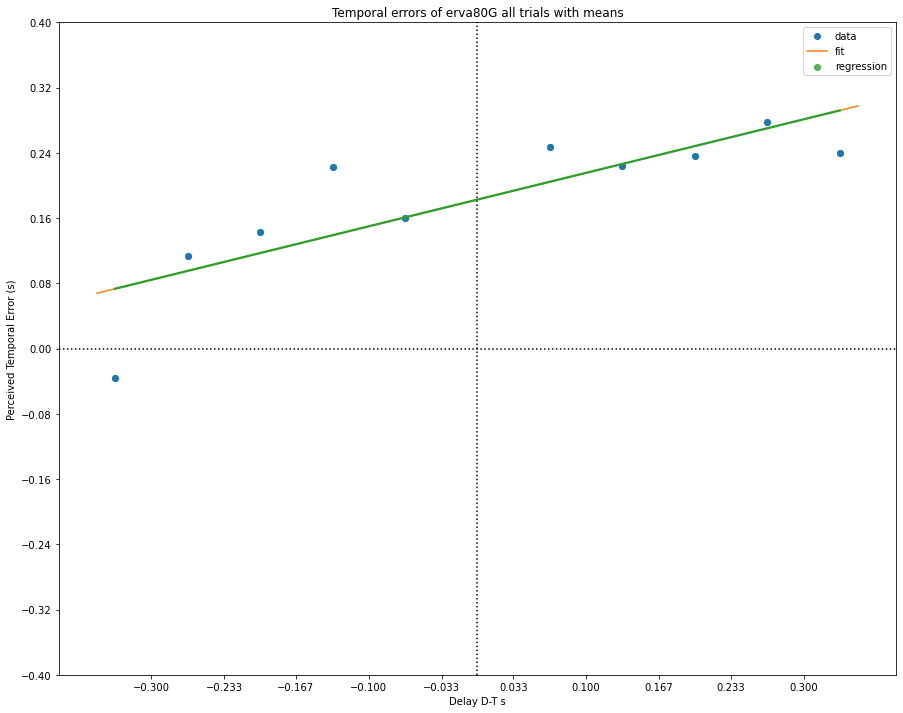

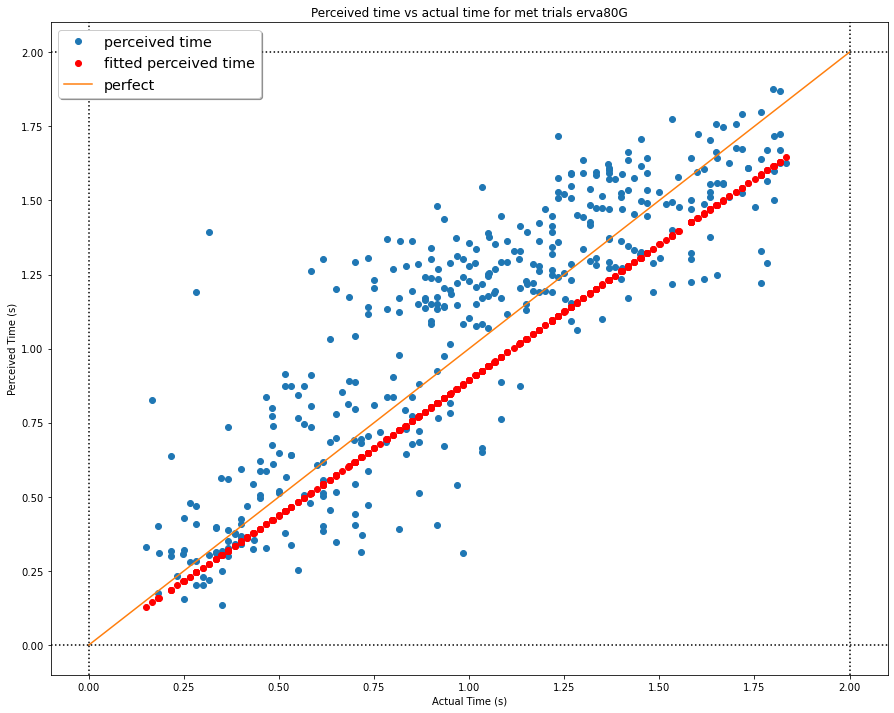

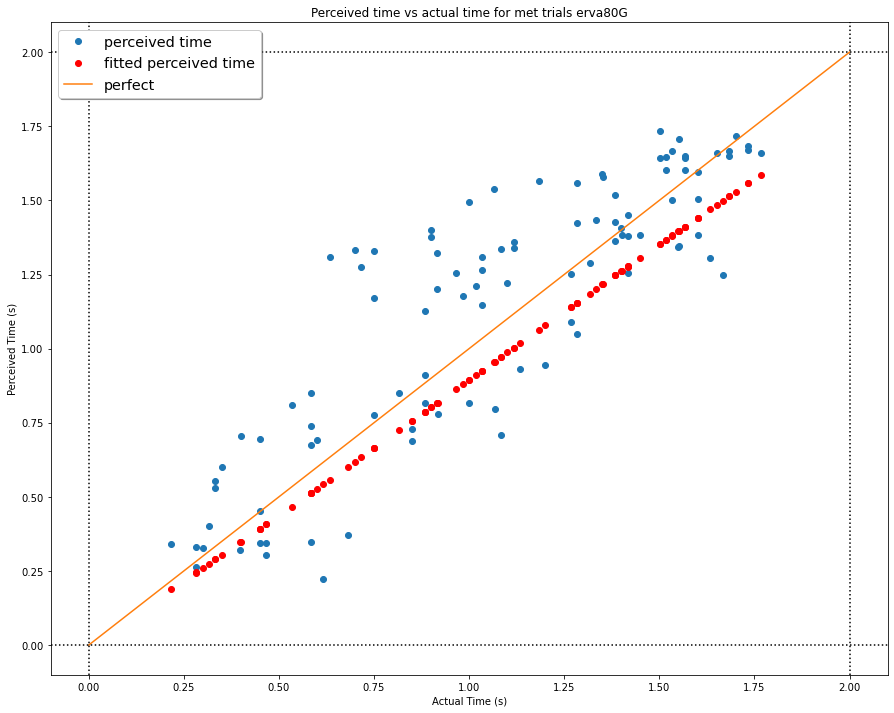

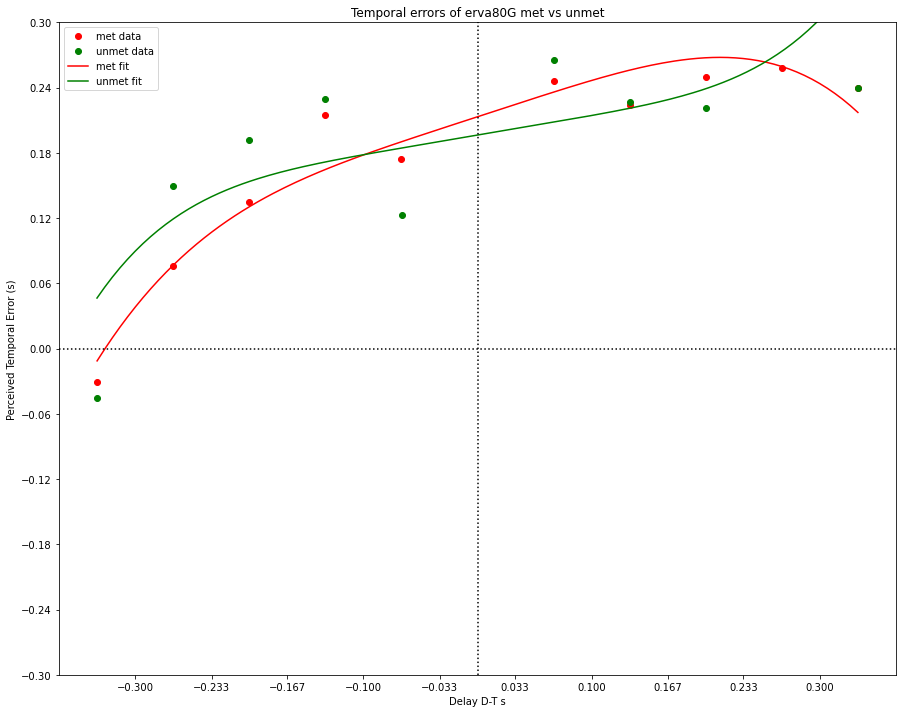

[3.93400466e+09 1.17533930e+10 2.37050301e+00 1.34441224e-02]
for met condition fit alpha is :713.6411542547526 fit sigma is :2131.7430510667245fit teta : -9.239742610113641
[3.66998760e-01 2.33924229e+00 2.11298653e-02 5.41523303e+01]
for unmet condition fit alpha is :0.09672032891513821 fit sigma is :0.42127241736438276fit teta : 0.18645953849258548


## 3.2 Perceived Error over Expected(unmet) trials

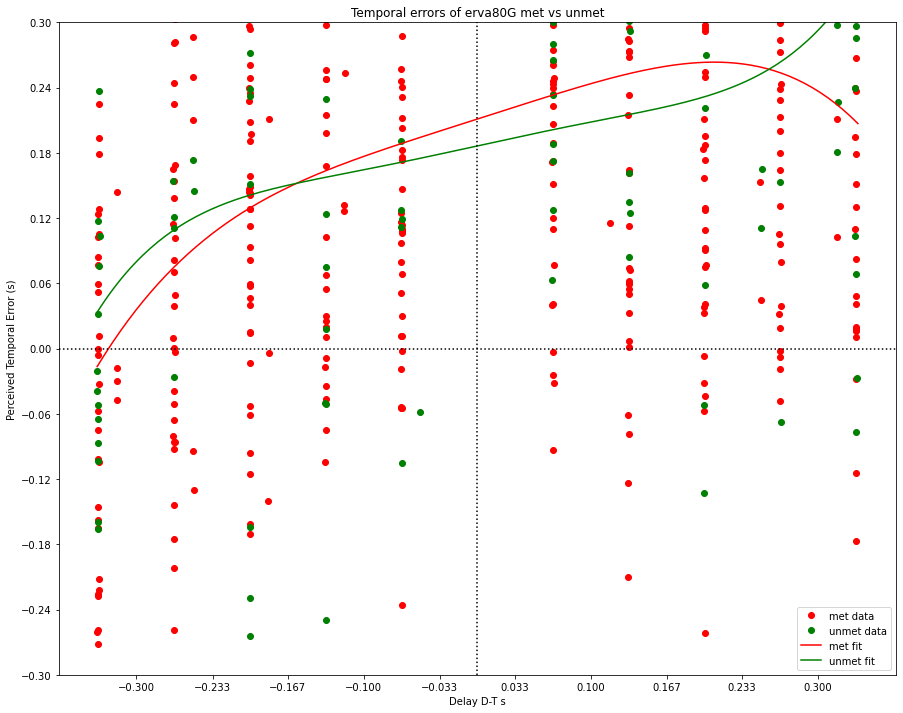

## 4 - Reaction Time differences between met and unmet trials

 Reaction time After Treshold for met conditions 0.9999910000000001
Reaction Time After Treshold for unmet condition 1.1671828


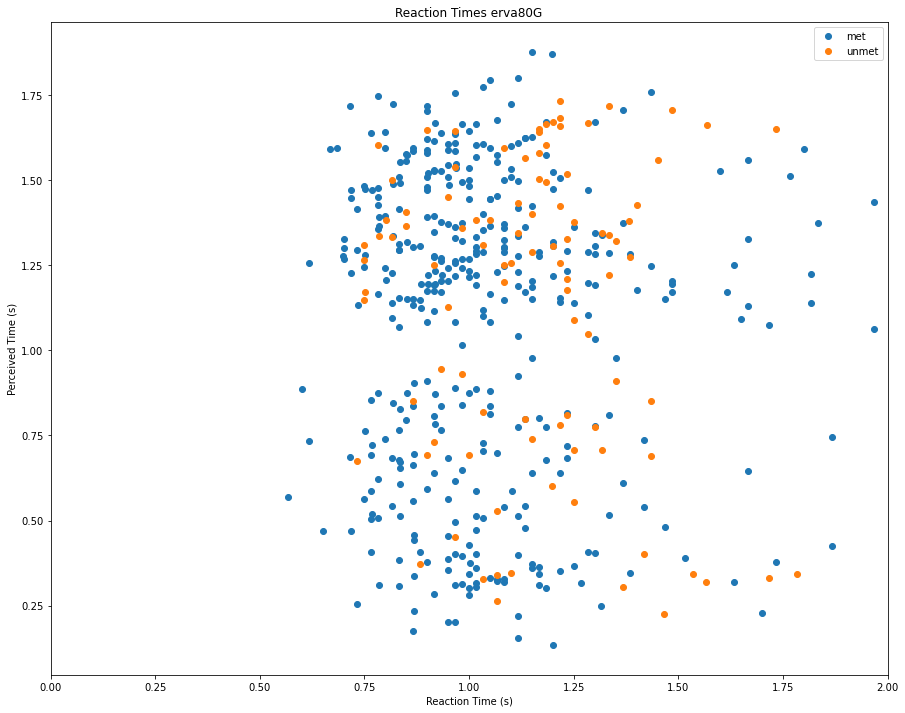

# ANALYSIS of omer80G DTATA

## 1 - Perceived time vs actual time for Test trials of omer80G data

## 2 - Perceived Error over all trials with baseline equation for temporal error (not considering the effect of the expectation)

## 2.2.1 - Perceived time vs actual time for met trials

## 2.2.2 - Perceived time vs actual time for unmet trials

[0.05909018 0.21460474 6.49379331 0.02517571]
for met condition fit alpha is :-0.1120625381535184 fit sigma is :-0.2849952733743593fit teta : 0.07525506958211822
[1.89171527e-01 2.74884629e-01 4.13696347e-02 1.10463974e+02]
for unmet condition fit alpha is :0.3703649715832299 fit sigma is :0.26339071494582134fit teta : 0.12701458479849553


## 3.1 Perceived Error over Expected(met) trials

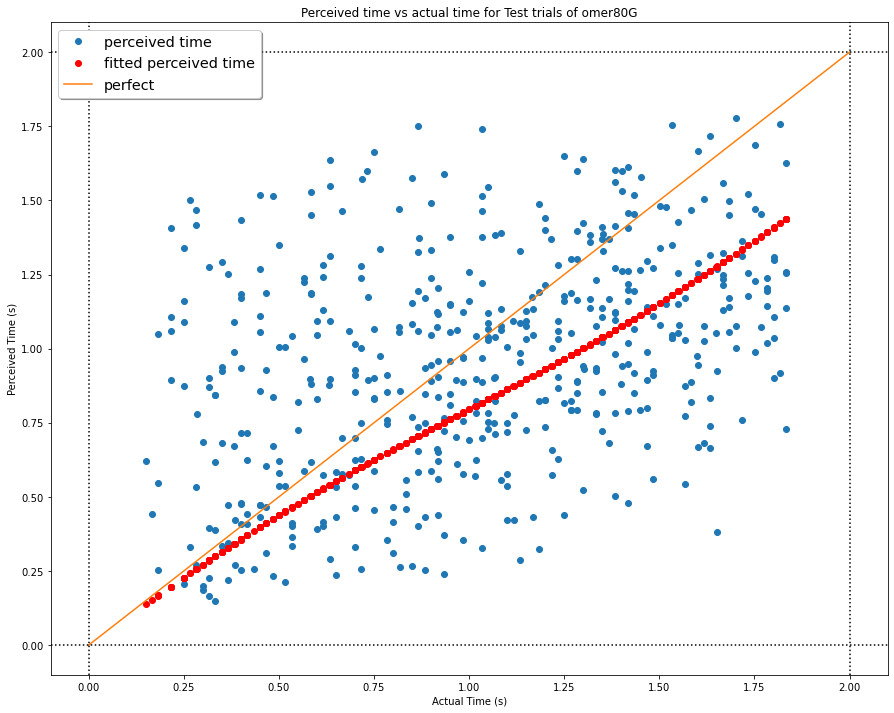

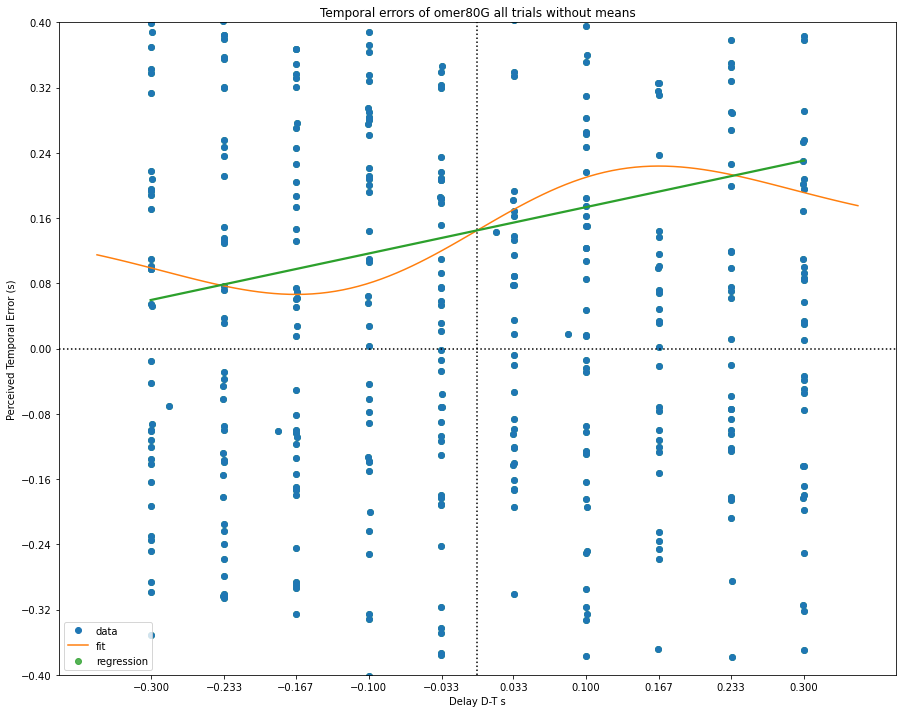

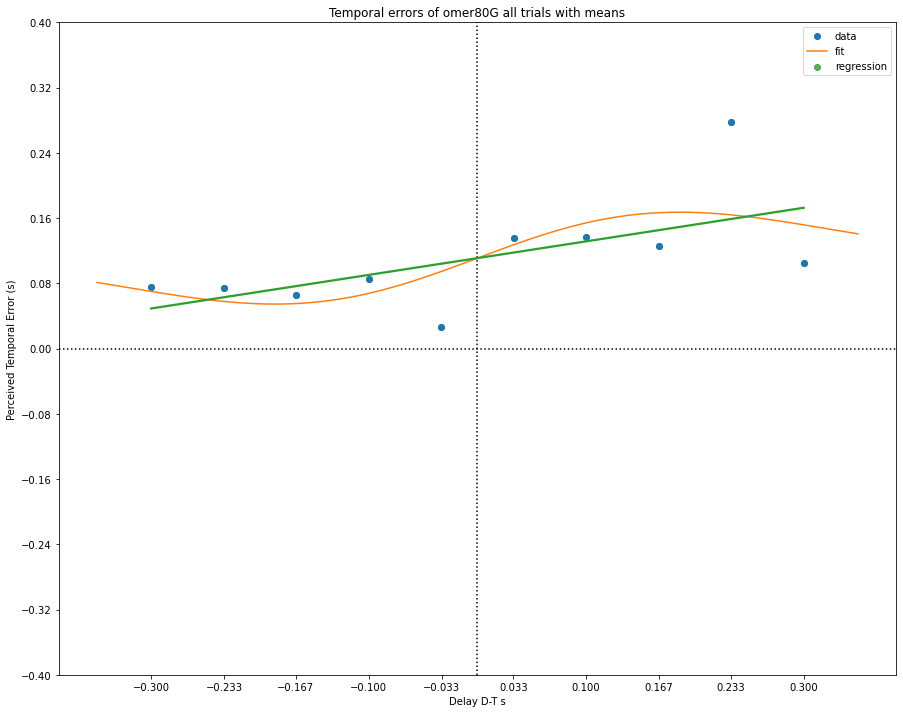

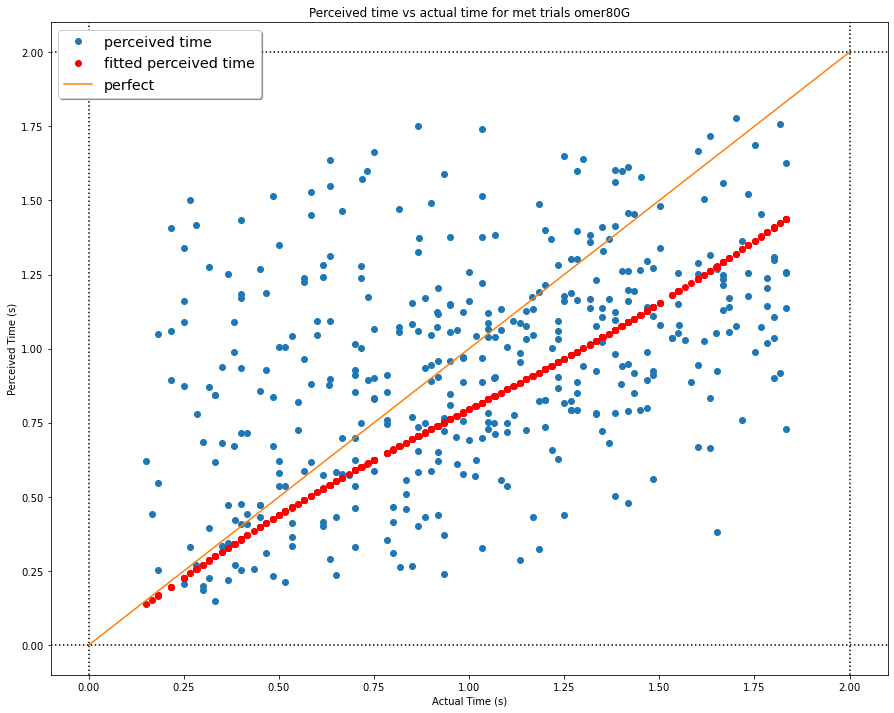

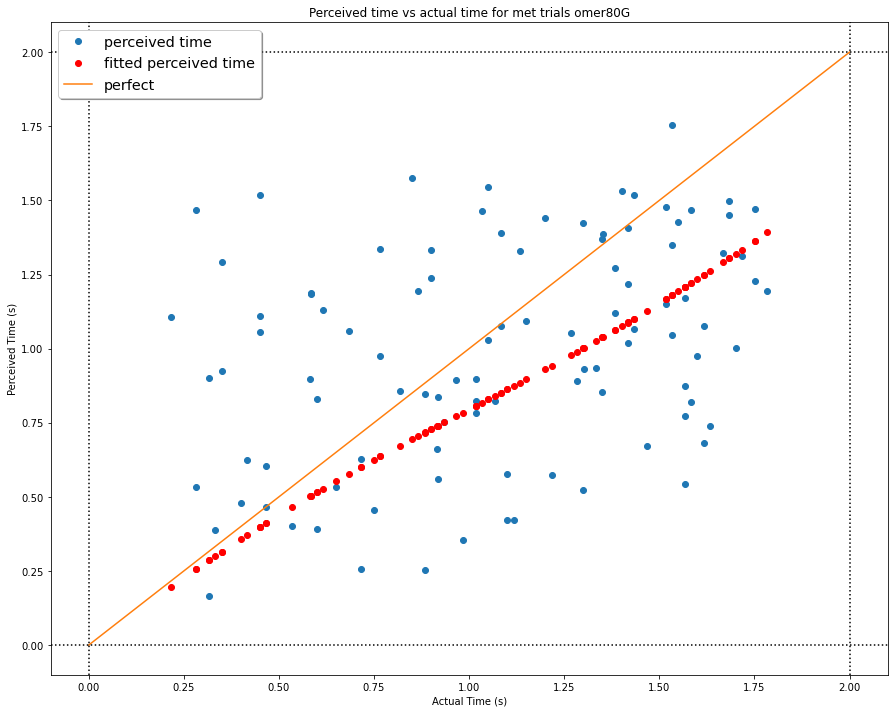

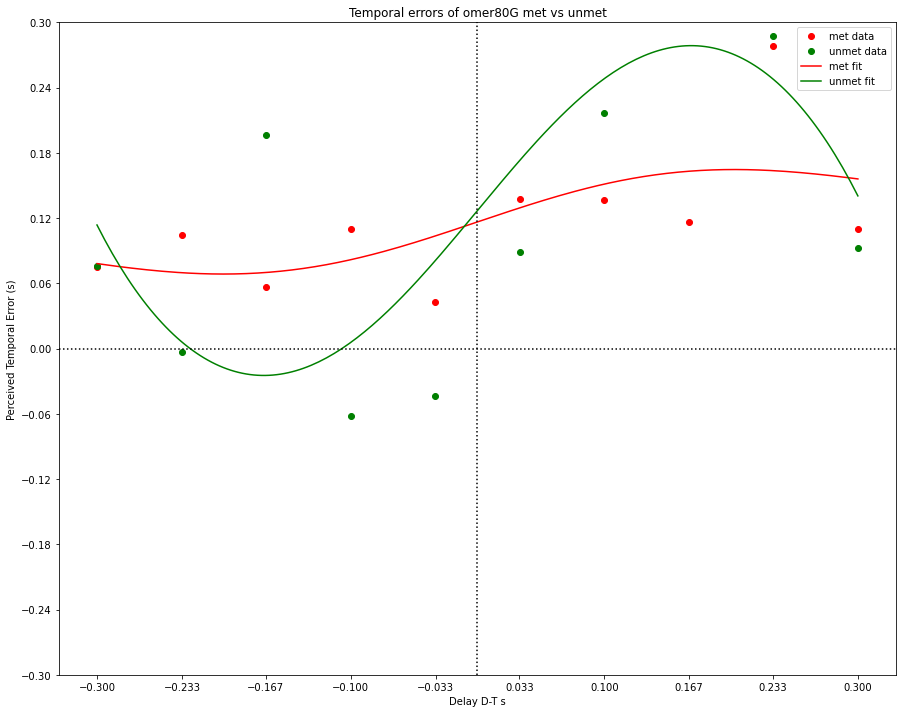

[0.05808801 0.12612932 6.39385886 0.02382398]
for met condition fit alpha is :-0.14761765594945844 fit sigma is :-0.2598771814893403fit teta : 6.804721055864195
[ 0.16330406  0.05312545  0.03868052 33.52198606]
for unmet condition fit alpha is :0.3803334587569266 fit sigma is :0.13900341003981617fit teta : 0.14761602512637442


## 3.2 Perceived Error over Expected(unmet) trials

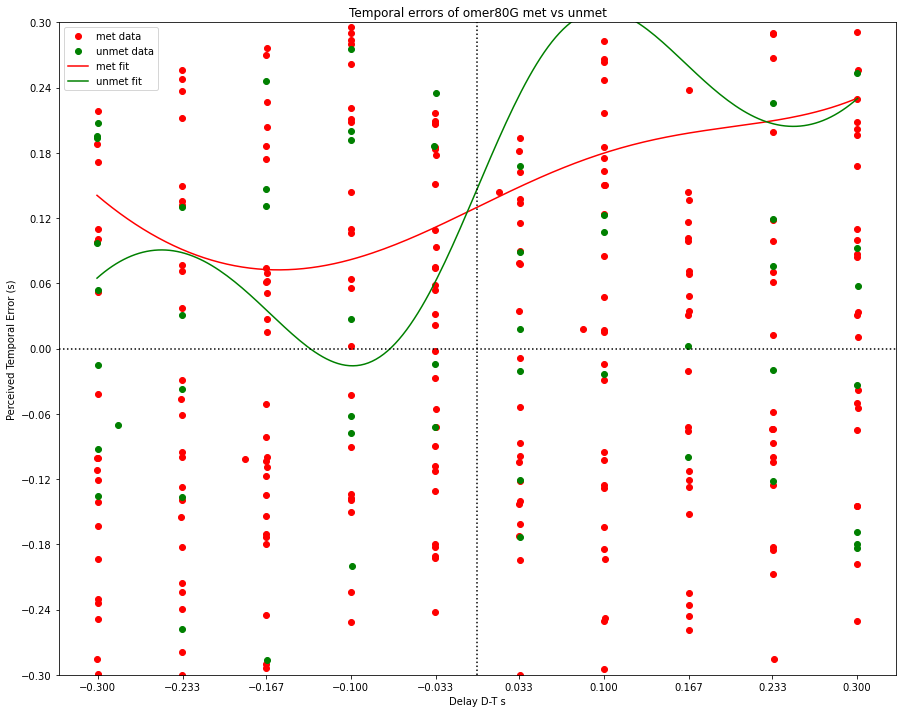

## 4 - Reaction Time differences between met and unmet trials

 Reaction time After Treshold for met conditions 1.4670861499907915
Reaction Time After Treshold for unmet condition 1.5341659999685362


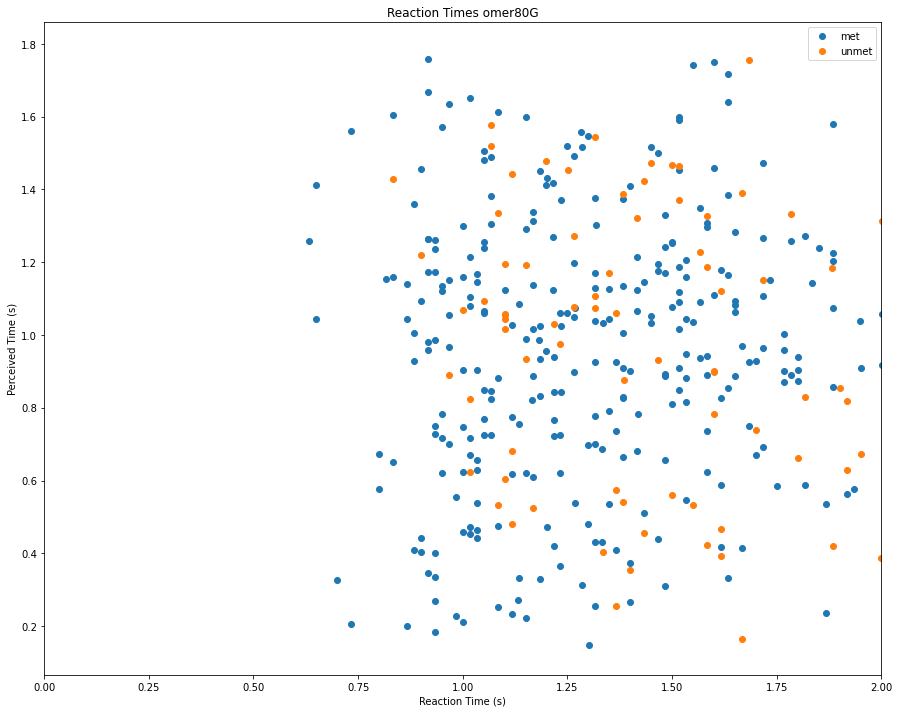

# ANALYSIS of nicola DTATA

## 1 - Perceived time vs actual time for Test trials of nicola data

## 2 - Perceived Error over all trials with baseline equation for temporal error (not considering the effect of the expectation)

## 2.2.1 - Perceived time vs actual time for met trials

## 2.2.2 - Perceived time vs actual time for unmet trials

[3.43609380e+10 1.18884694e+11 5.54251977e+00 2.33762996e-02]
for met condition fit alpha is :1447.747377280595 fit sigma is :5008.803606899518fit teta : -5.154387691778004
[3.34211605e+10 1.01969479e+11 3.58328642e-02 7.81762957e+01]
for unmet condition fit alpha is :1433.1942360004891 fit sigma is :4372.913567191519fit teta : 0.024460568830807116


## 3.1 Perceived Error over Expected(met) trials

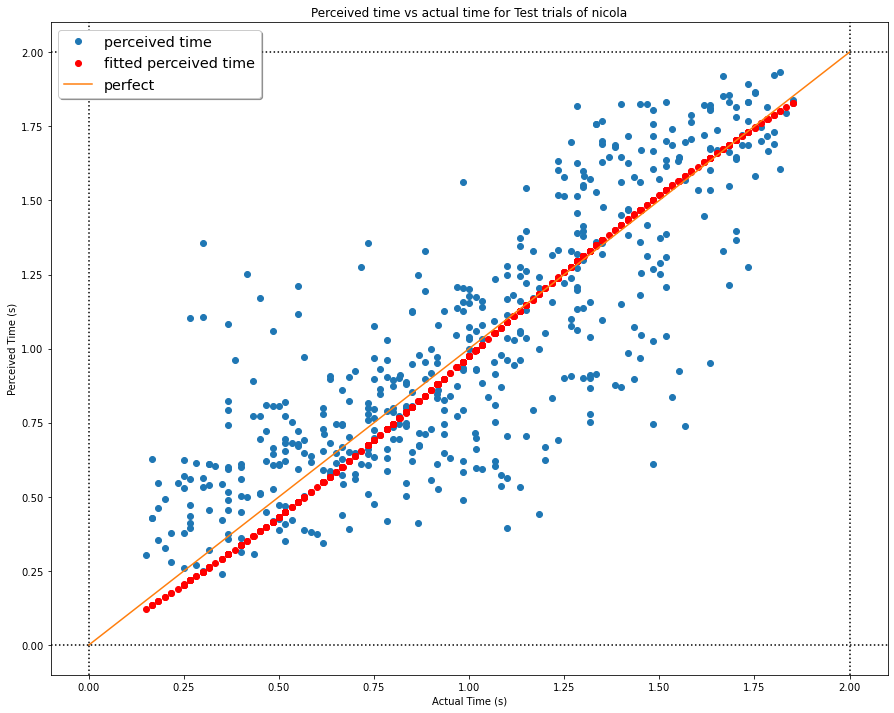

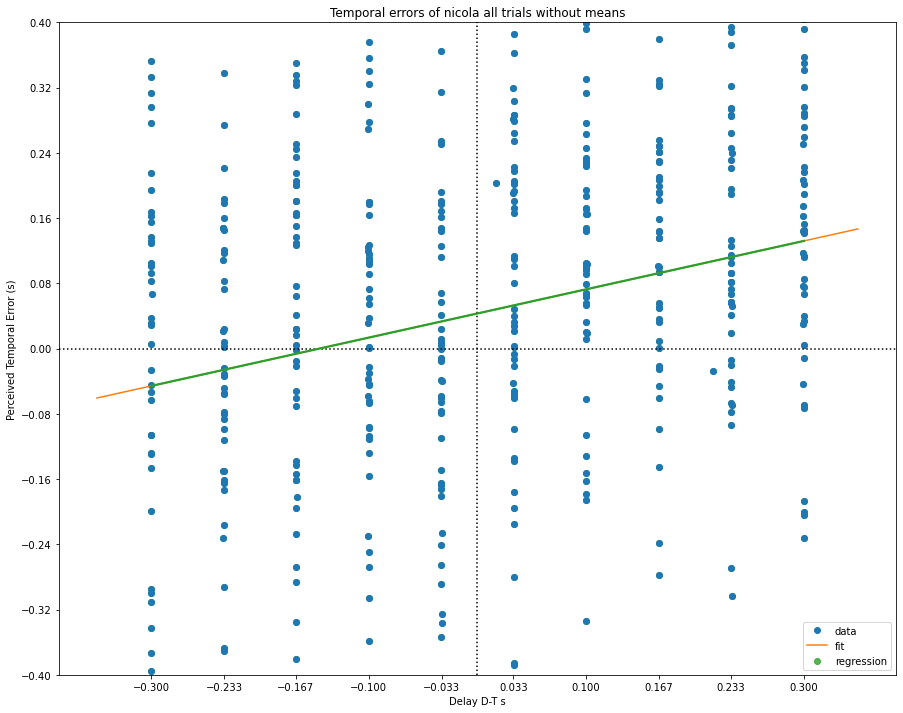

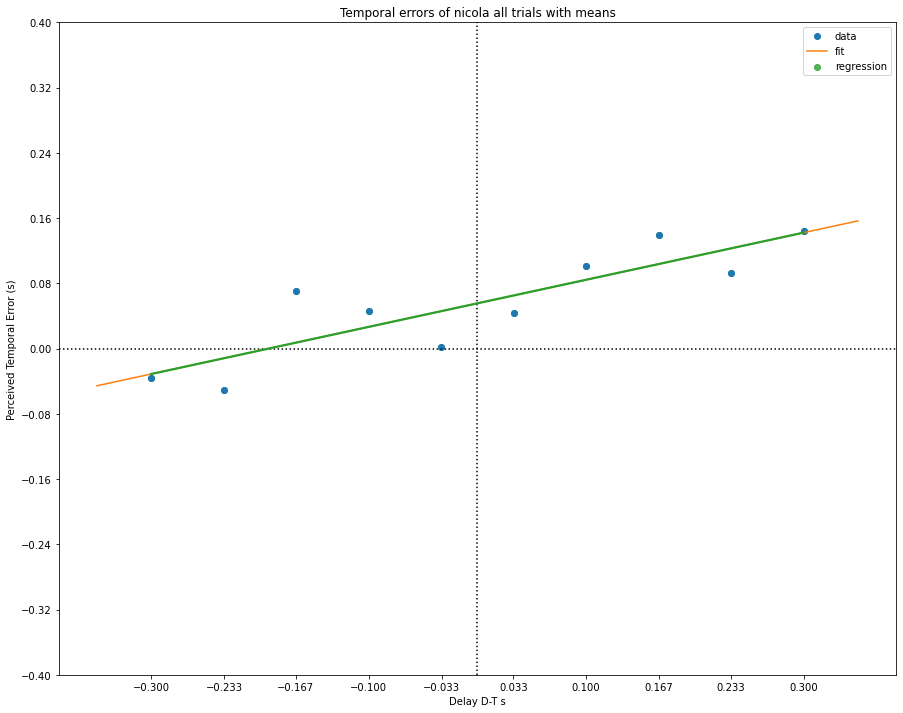

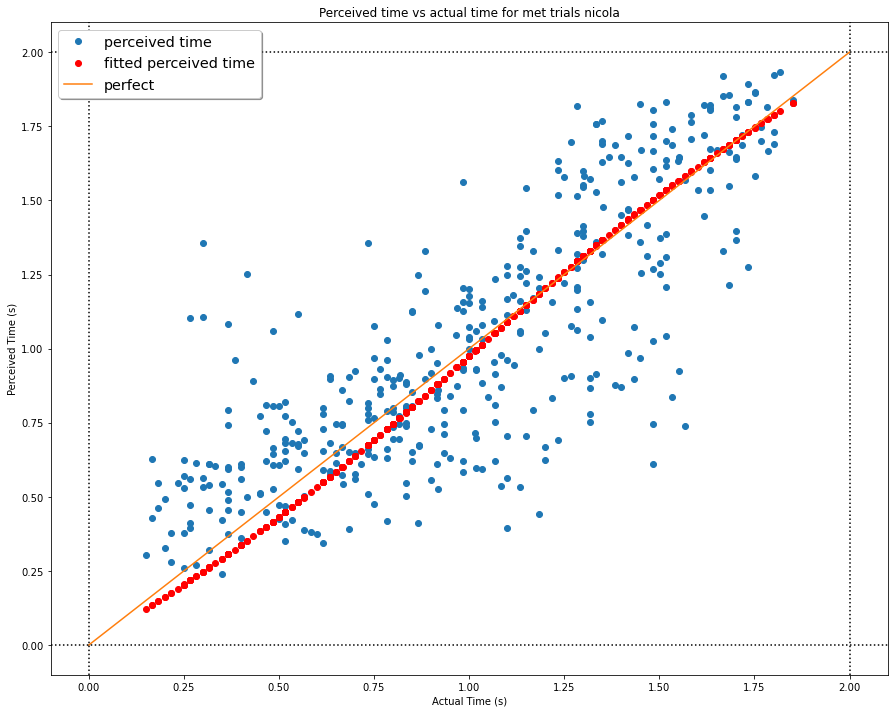

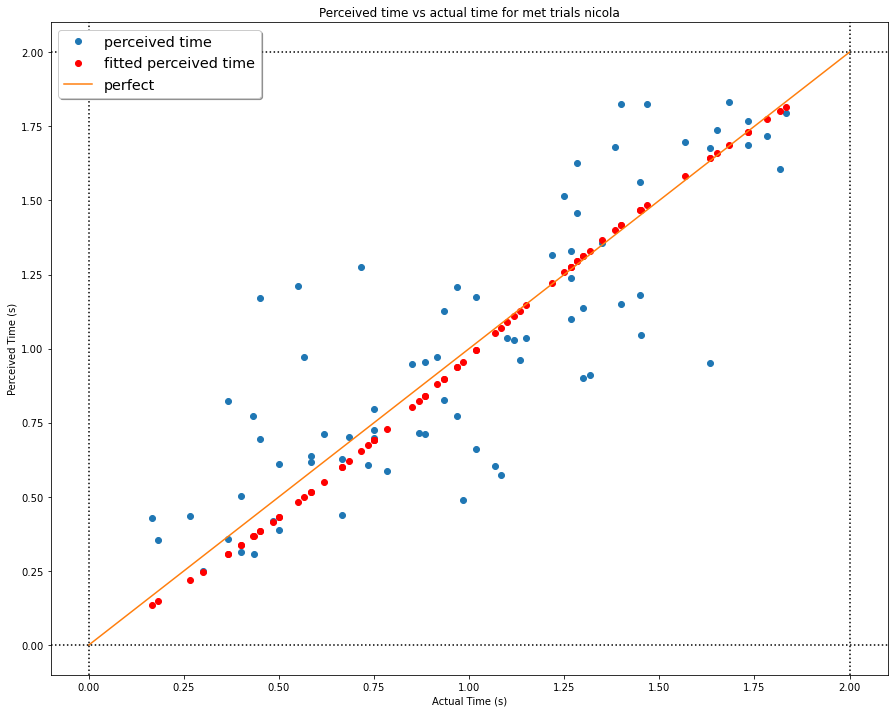

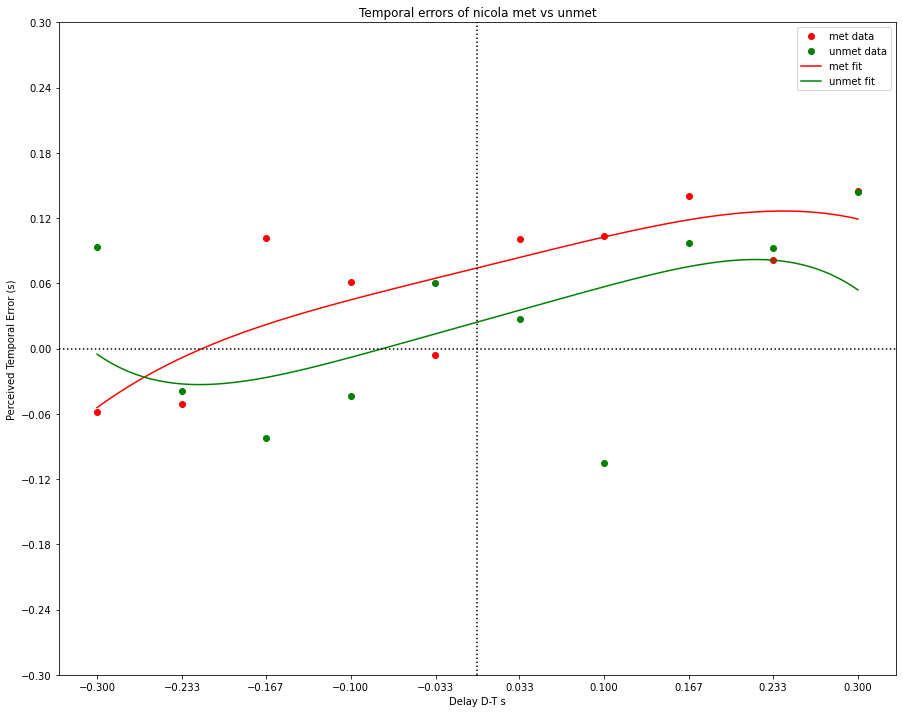

[3.52856022e+09 1.00527808e+10 4.31207971e+00 1.63725781e-02]
for met condition fit alpha is :1219.8314304593475 fit sigma is :3475.9280827548155fit teta : -5.624672367655679
[ 0.1643408   0.07486383  0.03219565 25.4243953 ]
for unmet condition fit alpha is :-0.11888405023334027 fit sigma is :0.06773440311456129fit teta : 0.0368314590495108


## 3.2 Perceived Error over Expected(unmet) trials

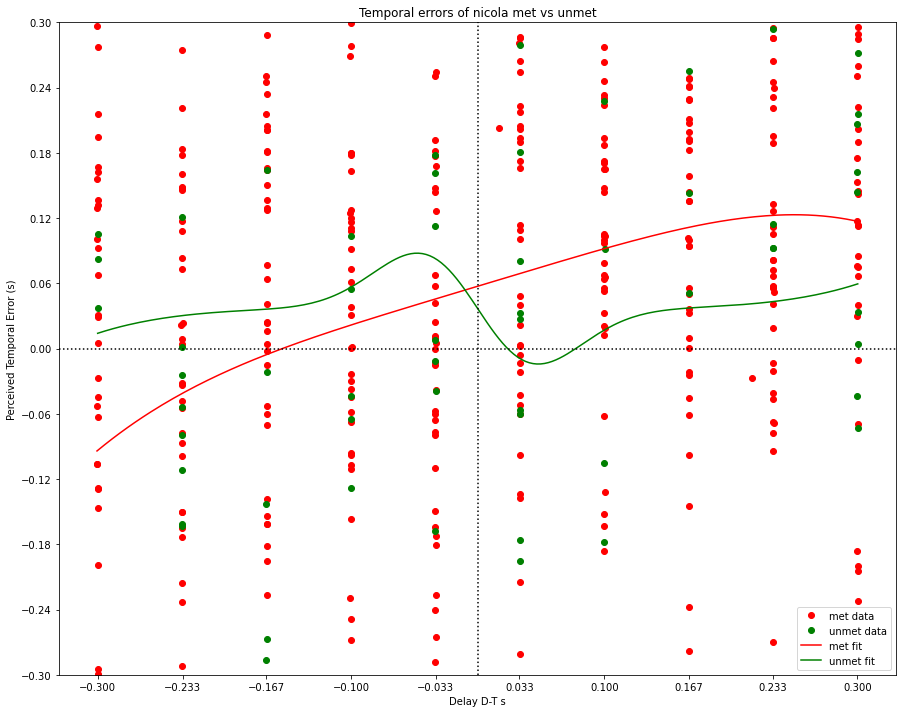

## 4 - Reaction Time differences between met and unmet trials

 Reaction time After Treshold for met conditions 0.8838482000282966
Reaction Time After Treshold for unmet condition 0.9006637000129558


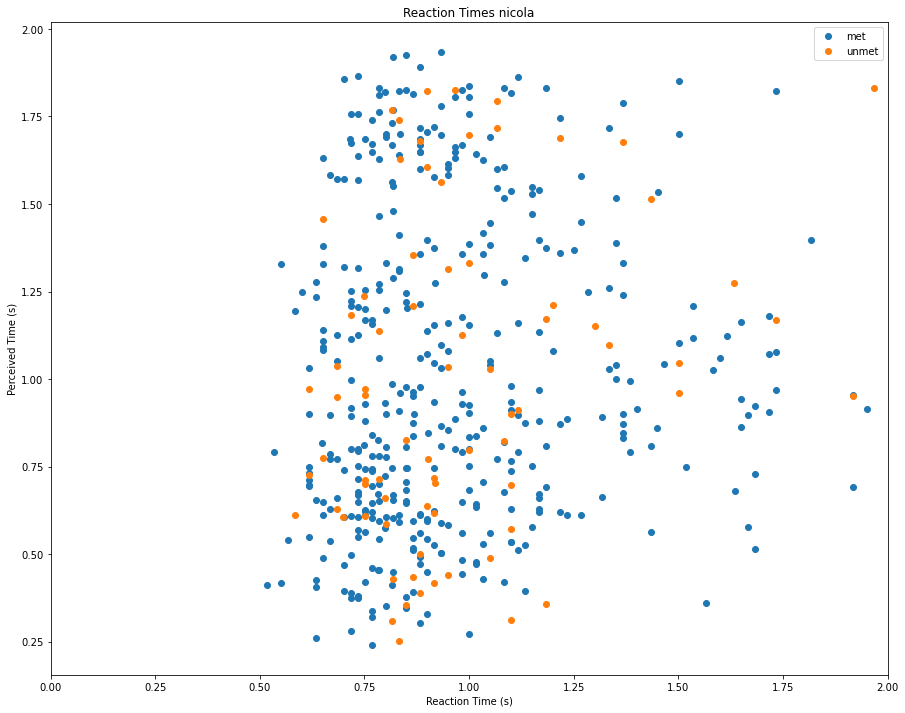

# ANALYSIS of elaine08R DTATA

## 1 - Perceived time vs actual time for Test trials of elaine08R data

## 2 - Perceived Error over all trials with baseline equation for temporal error (not considering the effect of the expectation)

## 2.2.1 - Perceived time vs actual time for met trials

## 2.2.2 - Perceived time vs actual time for unmet trials

[0.06421821 0.37039092 3.60674132 0.02173053]
for met condition fit alpha is :0.16085113911450039 fit sigma is :0.44212928245990873fit teta : 6.56457128290114
[2.07651894e+09 5.67288664e+09 3.09569220e-02 1.63877610e+02]
for unmet condition fit alpha is :252.66494541753218 fit sigma is :690.2324217416761fit teta : 0.11499130756159129


## 3.1 Perceived Error over Expected(met) trials

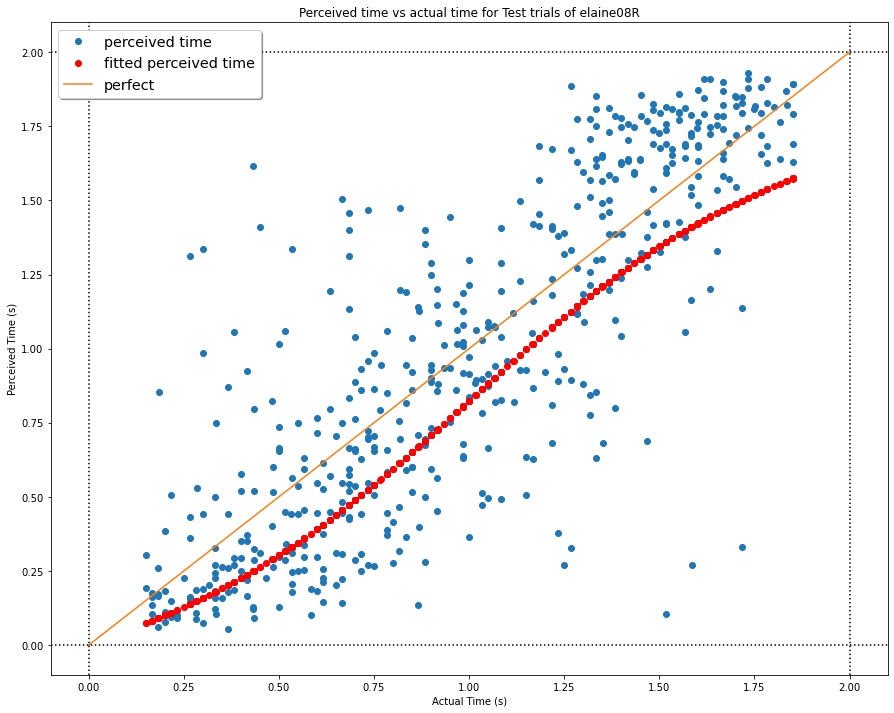

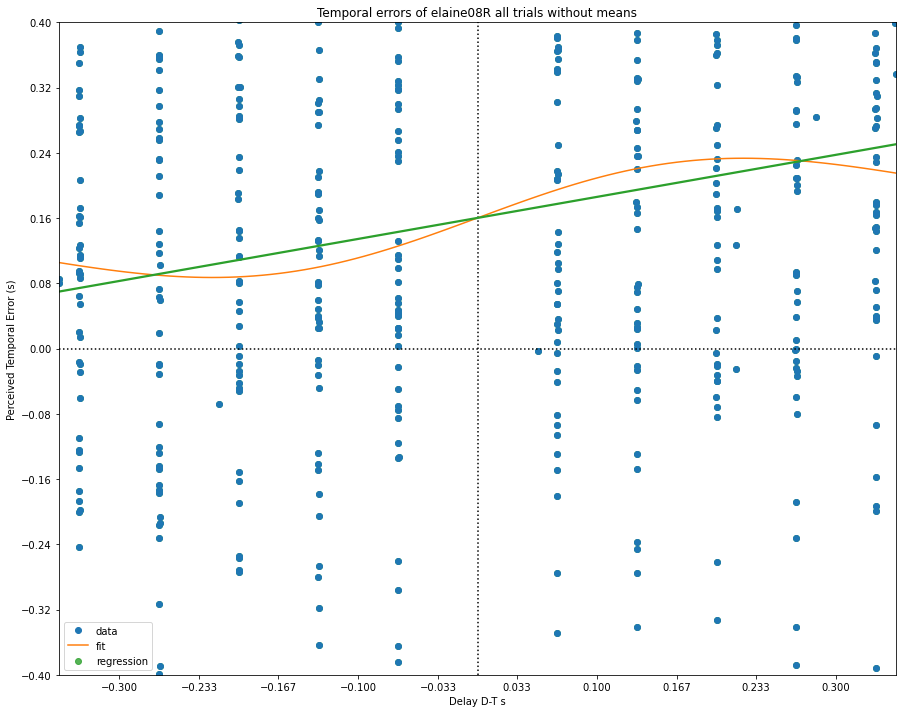

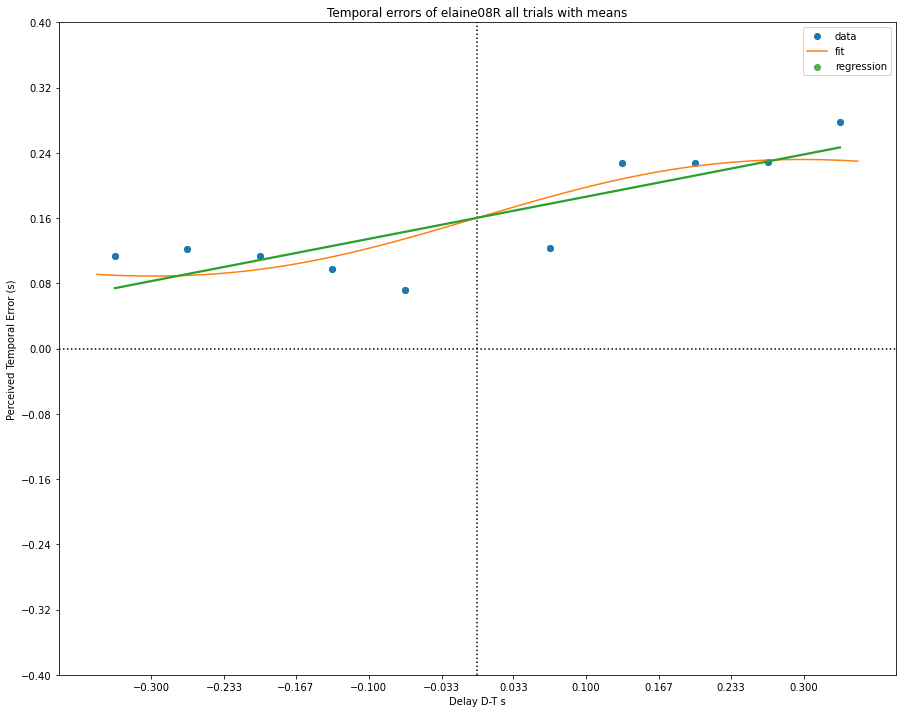

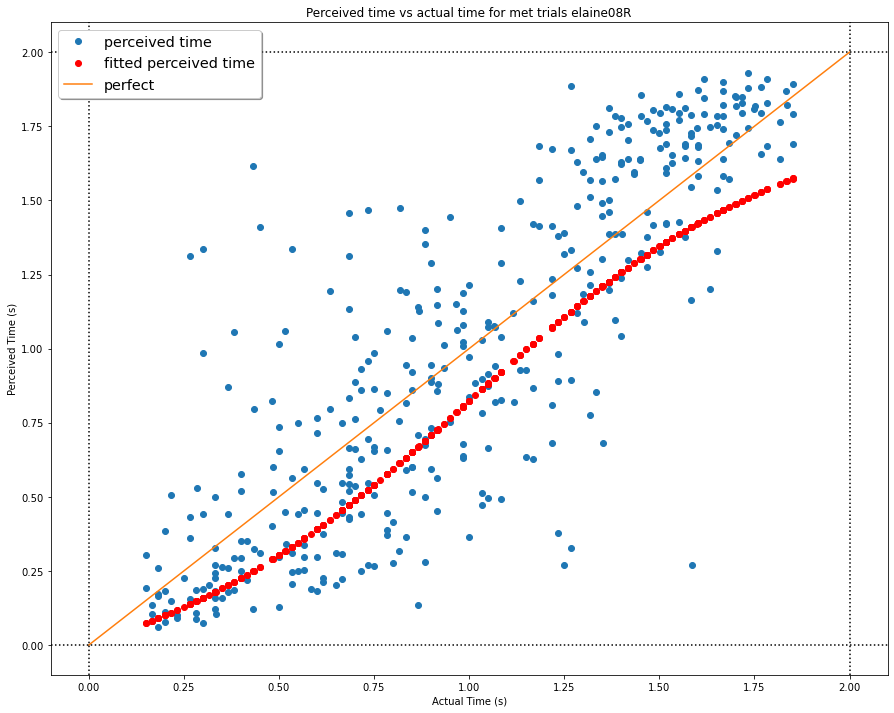

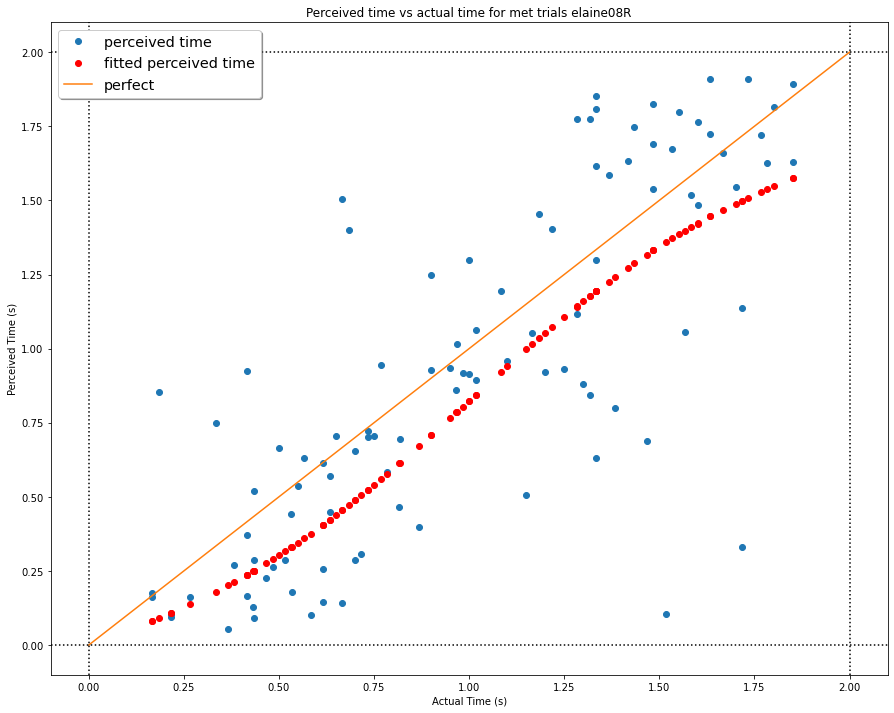

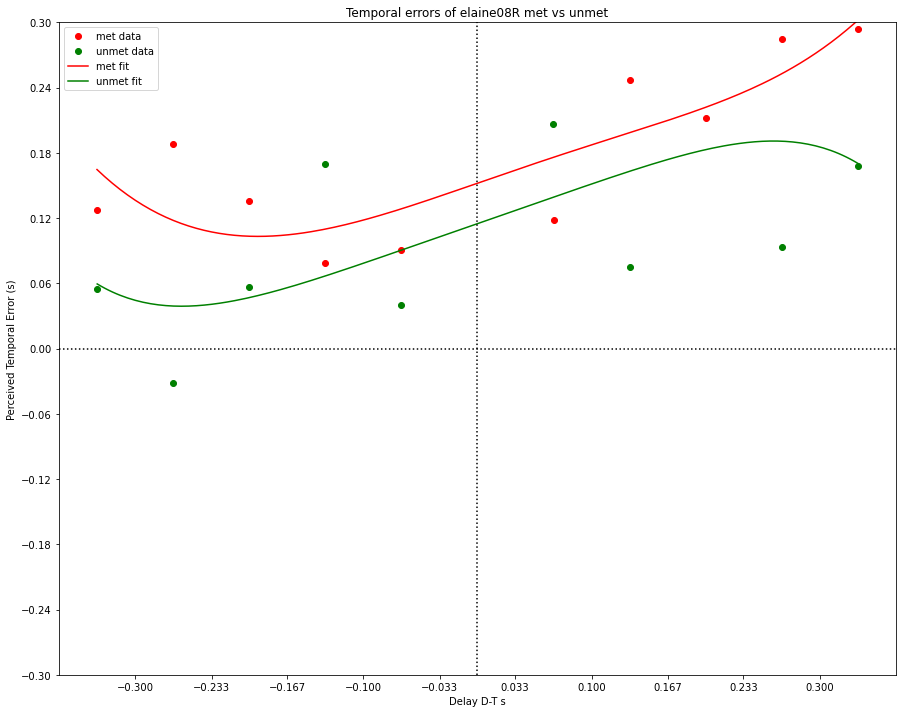

[0.04324252 0.11953842 3.13359611 0.01942841]
for met condition fit alpha is :-0.146624065511471 fit sigma is :-0.30620633681708026fit teta : 6.653174763179212
[1.15827951e-01 2.97027534e-01 3.56734247e-02 4.66928597e+01]
for unmet condition fit alpha is :0.22175638564020378 fit sigma is :0.2616092284092281fit teta : 0.0950903352344415


## 3.2 Perceived Error over Expected(unmet) trials

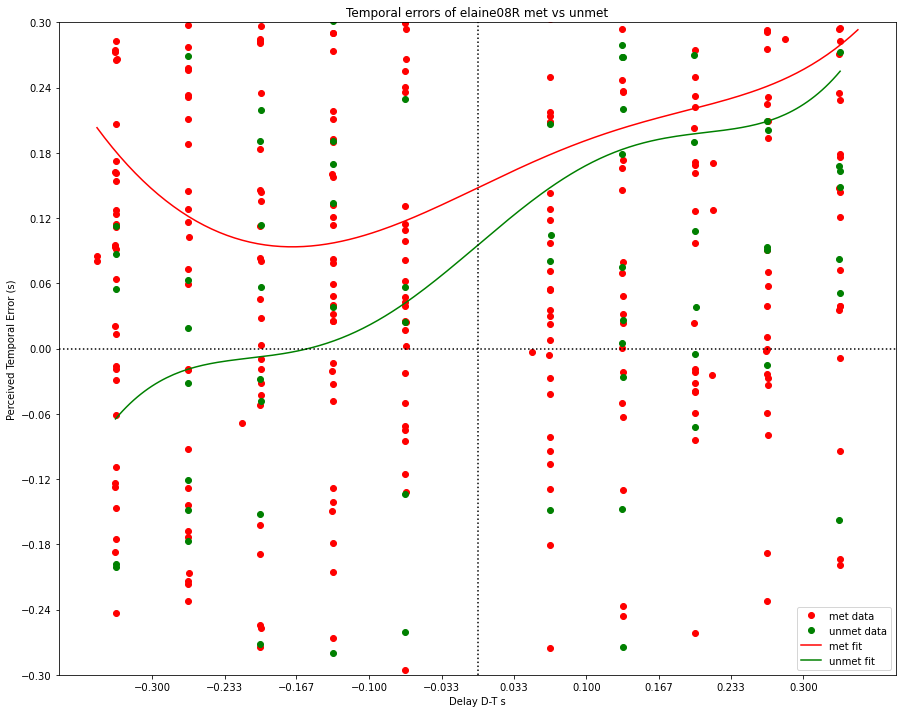

## 4 - Reaction Time differences between met and unmet trials

 Reaction time After Treshold for met conditions 1.9006659500300884
Reaction Time After Treshold for unmet condition 1.851010199985467


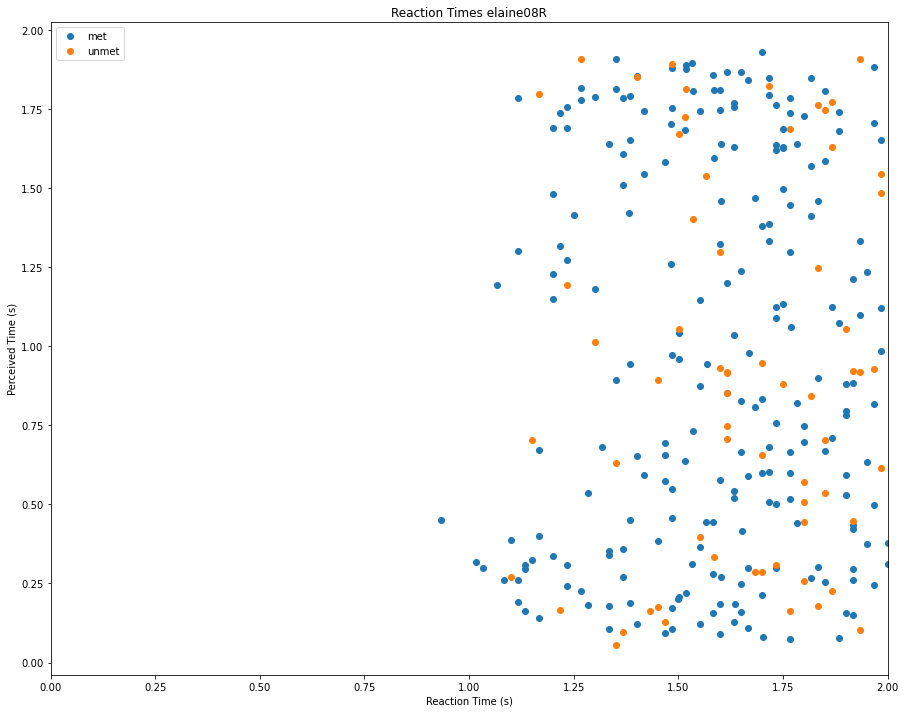

In [94]:
import warnings
warnings.filterwarnings('ignore')


for data in datas_expecataions_80:
    df_obj,df_trial,df_test,df_long,df_met,df_unmet,df_name=load_data(path,data)
    display(Markdown('# ANALYSIS of {} DTATA'.format(str(df_name.split('_')[0]))))
    display(Markdown("## 1 - Perceived time vs actual time for Test trials of {} data".format(df_name.split('_')[0])))
    print("")
    plot_perceived_actual(df_trial)
    display(Markdown("## 2 - Perceived Error over all trials with baseline equation for temporal error (not considering the effect of the expectation)"))
    df_obj.plot_base_model(means=0)
    plt.title("Temporal errors of "+df_name.split('_')[0]+" all trials without means")
    df_obj.plot_base_model(means=1)
    plt.title("Temporal errors of "+df_name.split('_')[0]+" all trials with means")
    display(Markdown("## 2.2.1 - Perceived time vs actual time for met trials"))
    plot_perceived_actual(df_met)
    plt.title("Perceived time vs actual time for met trials "+df_name.split('_')[0])
    display(Markdown("## 2.2.2 - Perceived time vs actual time for unmet trials"))    
    plot_perceived_actual(df_unmet)
    plt.title("Perceived time vs actual time for met trials "+df_name.split('_')[0])

    mets=df_obj.fitter(means=1,congruency="met")
    unmets=df_obj.fitter(means=1,congruency="unmet")
    display(Markdown("## 3.1 Perceived Error over Expected(met) trials"))
    plot_mets_unmets(mets,unmets)
    mets=df_obj.fitter(means=0,congruency="met")
    unmets=df_obj.fitter(means=0,congruency="unmet")
    display(Markdown("## 3.2 Perceived Error over Expected(unmet) trials"))
    plot_mets_unmets(mets,unmets)
    display(Markdown("## 4 - Reaction Time differences between met and unmet trials"))
    print(" Reaction time After Treshold for met conditions "+str(np.median(df_met["rTAfterMotionTreshold"])))
    print("Reaction Time After Treshold for unmet condition "+str(np.median(df_unmet["rTAfterMotionTreshold"])))
    plt.figure(figsize=(15, 12))
    plt.plot(df_met["rTAfterMotionTreshold"],df_met["perceivedTime"],'o',label="met")
    plt.plot(df_unmet["rTAfterMotionTreshold"],df_unmet["perceivedTime"],'o',label="unmet")
    plt.title("Reaction Times "+df_name.split('_')[0])
    plt.ylabel("Perceived Time (s)")
    plt.xlabel("Reaction Time (s)")
    plt.legend()
    plt.xlim(0,2)
    plt.show()

